In [ ]:
import os, re
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import nibabel as nib
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms


In [ ]:
ROOT = Path(r"F:\university\milan\thesis\trento\code\disc1") 


In [ ]:
def find_candidate_volumes(root: Path):
    # search broadly
    matches = list(root.rglob("*.nii")) + list(root.rglob("*.nii.gz")) + list(root.rglob("*.img"))
    # drop .img that have no .hdr
    matches = [m for m in matches if not (m.suffix == ".img" and not (m.with_suffix(".hdr")).exists())]
    # exclude non-anatomical files
    bad_tokens = ("fseg","seg","pve","mask","t4","gif","raw")
    matches = [m for m in matches if not any(tok in str(m).lower() for tok in bad_tokens)]
    return matches

def subj_id_from_path(p: Path):
    m = re.search(r"(OAS1_\d{4})", str(p))
    return m.group(1) if m else None

def quality_rank(p: Path) -> int:
    s = str(p).lower()
    if "t88_111_masked_gfc" in s: return 0
    if "t88_111" in s:            return 1
    if "subj_111" in s:           return 2
    return 3  # least preferred

all_candidates = find_candidate_volumes(ROOT)
rows = []
for p in all_candidates:
    sid = subj_id_from_path(p)
    if sid:
        rows.append({"sid": sid, "path": p, "rank": quality_rank(p)})

df_cand = pd.DataFrame(rows)
print("Total candidate files:", len(df_cand), "| unique subjects:", df_cand["sid"].nunique())

best = (
    df_cand.sort_values(["sid","rank"])
           .groupby("sid", as_index=False)
           .first()
)
mri_paths = best["path"].tolist()
subject_ids = best["sid"].tolist()
print("Chosen 1 per subject:", len(mri_paths))
for p in mri_paths[:10]:
    print(" ↳", p)


Total candidate files: 78 | unique subjects: 39
Chosen 1 per subject: 39
 ↳ F:\university\milan\thesis\trento\code\disc1\OAS1_0001_MR1\PROCESSED\MPRAGE\T88_111\OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc.img
 ↳ F:\university\milan\thesis\trento\code\disc1\OAS1_0002_MR1\PROCESSED\MPRAGE\T88_111\OAS1_0002_MR1_mpr_n4_anon_111_t88_gfc.img
 ↳ F:\university\milan\thesis\trento\code\disc1\OAS1_0003_MR1\PROCESSED\MPRAGE\T88_111\OAS1_0003_MR1_mpr_n4_anon_111_t88_gfc.img
 ↳ F:\university\milan\thesis\trento\code\disc1\OAS1_0004_MR1\PROCESSED\MPRAGE\T88_111\OAS1_0004_MR1_mpr_n4_anon_111_t88_gfc.img
 ↳ F:\university\milan\thesis\trento\code\disc1\OAS1_0005_MR1\PROCESSED\MPRAGE\T88_111\OAS1_0005_MR1_mpr_n4_anon_111_t88_gfc.img
 ↳ F:\university\milan\thesis\trento\code\disc1\OAS1_0006_MR1\PROCESSED\MPRAGE\T88_111\OAS1_0006_MR1_mpr_n4_anon_111_t88_gfc.img
 ↳ F:\university\milan\thesis\trento\code\disc1\OAS1_0007_MR1\PROCESSED\MPRAGE\T88_111\OAS1_0007_MR1_mpr_n3_anon_111_t88_gfc.img
 ↳ F:\university\milan\t

In [ ]:
idx = 0
vol_path = mri_paths[idx]
print("Viewing:", vol_path)


img = nib.load(str(vol_path))

# Reorient to RAS for consistent viewing (R=left→right, A=posterior→anterior, S=inferior→superior)
img_ras = nib.as_closest_canonical(img)

data = img_ras.get_fdata()
# Some Analyze files are 4D with a singleton last dim -> squeeze it
if data.ndim == 4 and data.shape[-1] == 1:
    data = data[..., 0]

print("Shape:", data.shape, "dtype:", data.dtype)
print("Voxel sizes (mm):", img_ras.header.get_zooms())
print("Axis codes:", nib.aff2axcodes(img_ras.affine))


Viewing: F:\university\milan\thesis\trento\code\disc1\OAS1_0001_MR1\PROCESSED\MPRAGE\T88_111\OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc.img
Shape: (176, 208, 176) dtype: float64
Voxel sizes (mm): (1.0, 1.0, 1.0, 0.0)
Axis codes: ('R', 'A', 'S')


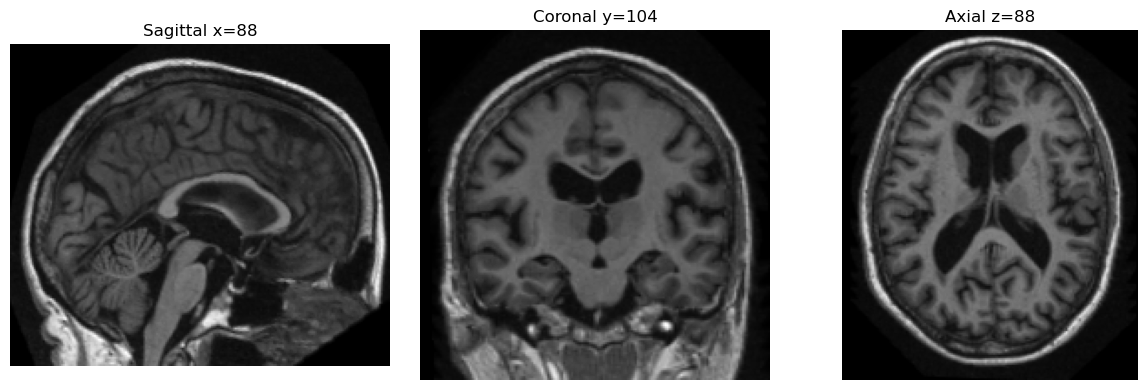

In [5]:
import matplotlib.pyplot as plt

# Choose mid indices
cx = data.shape[0] // 2
cy = data.shape[1] // 2
cz = data.shape[2] // 2

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Sagittal (x-slice)
axes[0].imshow(np.rot90(data[cx, :, :]), cmap="gray")
axes[0].set_title(f"Sagittal x={cx}")
axes[0].axis("off")

# Coronal (y-slice)
axes[1].imshow(np.rot90(data[:, cy, :]), cmap="gray")
axes[1].set_title(f"Coronal y={cy}")
axes[1].axis("off")

# Axial (z-slice)
axes[2].imshow(np.rot90(data[:, :, cz]), cmap="gray")
axes[2].set_title(f"Axial z={cz}")
axes[2].axis("off")

plt.tight_layout()
plt.show()


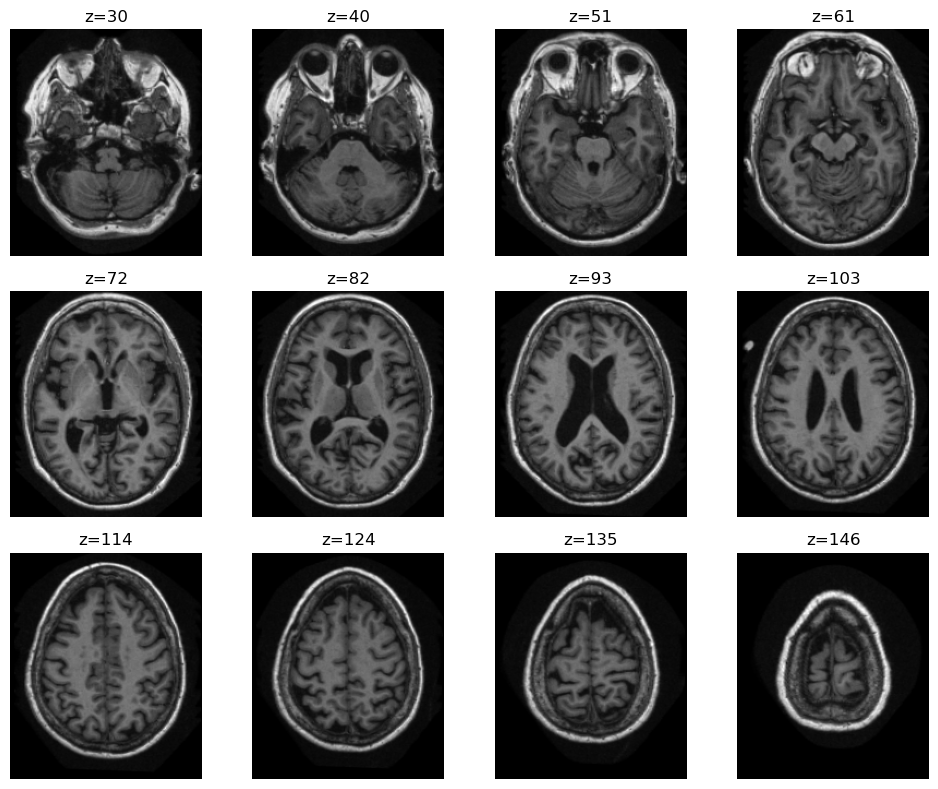

In [6]:
# Pick 12 slices spread through the brain
num = 12
z_idx = np.linspace(max(0, cz - data.shape[2]//3),
                    min(data.shape[2]-1, cz + data.shape[2]//3),
                    num=num, dtype=int)

fig, axes = plt.subplots(3, 4, figsize=(10, 8))
for ax, zi in zip(axes.ravel(), z_idx):
    ax.imshow(np.rot90(data[:, :, zi]), cmap="gray")
    ax.set_title(f"z={zi}")
    ax.axis("off")
plt.tight_layout()
plt.show()


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Identity()
resnet = resnet.eval().to(device)

print("Device:", device)


c:\Users\ARASH\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ARASH\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: cuda


In [10]:
class MRISliceDataset(Dataset):
    def __init__(self, paths, sids, num_slices=20):
        self.paths = list(paths)
        self.sids  = list(sids)
        self.num_slices = int(num_slices)
        # transforms: tensor -> resize -> 3ch repeat -> imagenet norm
        self.tf = transforms.Compose([
            transforms.ToTensor(),         # (H,W) -> (1,H,W)
            transforms.Resize((224,224)),
            transforms.Lambda(lambda x: x.repeat(3,1,1)),  # 1->3ch
            transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std=[0.229,0.224,0.225]),
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        sid  = self.sids[idx]

        vol = nib.load(str(path)).get_fdata()
        # Some Analyze files come as (X,Y,Z,1)
        if vol.ndim == 4 and vol.shape[-1] == 1:
            vol = vol[...,0]

        # z-score per volume
        std = float(vol.std())
        if std < 1e-8: std = 1.0
        vol = (vol - float(vol.mean())) / std

        # choose slices spread around the center
        z = vol.shape[2]
        z_center = z // 2
        extent   = self.num_slices * 2            # spread window
        z_start  = max(0, z_center - extent//2)
        z_end    = min(z-1, z_center + extent//2)
        z_idx    = np.linspace(z_start, z_end, num=self.num_slices, dtype=int)

        # build batch of slices (num_slices, 3, 224, 224)
        slices = [self.tf(vol[:,:,int(zi)].astype(np.float32)) for zi in z_idx]
        batch  = torch.stack(slices, dim=0)
        return batch, sid


In [11]:
dataset = MRISliceDataset(mri_paths, subject_ids, num_slices=20)
loader  = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

emb_list = []
sid_list = []

with torch.no_grad():
    for batch, sid in tqdm(loader):
        # batch: (B=1, S, 3, 224, 224) -> (S, 3, 224, 224)
        batch = batch.squeeze(0).to(device)
        feats = resnet(batch)                 # (S, 512)
        subj_emb = feats.mean(dim=0).cpu().numpy()  # (512,)
        emb_list.append(subj_emb)
        sid_list.append(sid[0])

X = np.vstack(emb_list)          # (N_subjects, 512)
print("Embeddings shape:", X.shape, "| subjects:", len(sid_list))


100%|██████████| 39/39 [00:06<00:00,  6.05it/s]

Embeddings shape: (39, 512) | subjects: 39


In [12]:
outdir = Path("results_resnet")
outdir.mkdir(exist_ok=True)

# CSV with subject id as index and 512 feature columns
df_emb = pd.DataFrame(X, index=sid_list, columns=[f"e{i}" for i in range(X.shape[1])])
df_emb.to_csv(outdir / "resnet_embeddings.csv")
print("Saved:", (outdir / "resnet_embeddings.csv").resolve())


Saved: F:\university\milan\thesis\trento\code\results_resnet\resnet_embeddings.csv
